In [12]:

import os
os.system('pip3 install Seaborn')
os.system('pip3 install xgboost')

0

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Load in all the data
samplesubmission = pd.read_csv('data/samplesubmission.csv')
solution_template = pd.read_csv('data/solution_template.csv')
training = pd.read_csv('data/training_v2.csv')
unlabeled = pd.read_csv('data/unlabeled.csv')
wids = pd.read_csv('data/WiDS_Datathon_2020_Dictionary.csv')

# CSV files must be in folder called 'data' in the same directory as the notebook 

In [14]:
# Find all the categorical features and set them to their appropriate type

num_unique_values = training.nunique().sort_values(ascending=False)
display(num_unique_values)
# After manually inspecting it seems that hospital_admit_source is the last categorical feature
# So we'll convert all columns with less unique values to a categorical feature as well
categorical_features = num_unique_values[num_unique_values <= 15].index
training_typed = training.astype(dict(zip(categorical_features, ['category'] * len(categorical_features))))

encounter_id             91713
patient_id               91713
bmi                      34888
urineoutput_apache       24772
pre_icu_los_days          9757
                         ...  
gcs_unable_apache            2
elective_surgery             2
gender                       2
apache_post_operative        2
readmission_status           1
Length: 186, dtype: int64

In [15]:
# Show the percentage of non missing values for each feature
missing = (training_typed.notna().sum() / len(training)) * 100

# Looking at the data there is a big gap in data availability between wbc_apache and urineoutput_apache, namely 75% and then 46%
# To make analysis easier we'll only consider features with more than 50% data availability
chosen_features = list(missing[missing > 50].index)

In [16]:
df_training = training_typed[chosen_features].fillna(training_typed[chosen_features].mean(numeric_only=True))
df_training = df_training.loc[(df_training['temp_apache'] >= 15) & (df_training['temp_apache'] <= 45) & (df_training['h1_temp_min'] >= 15) & (df_training['h1_temp_max'] <= 45)]
# df_training.select_dtypes(include=['category'])
# df_final = pd.get_dummies(df_training)

In [17]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes

In [18]:
from sklearn.model_selection import train_test_split

X = df_training.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], # drop APACHE scores
                   axis=1)
y = df_training['hospital_death'].copy()
y_apache = df_training['apache_4a_hospital_death_prob'].copy()

X = pd.get_dummies(X, drop_first=True)

# split the dataset into train and test+validation set
(X_train, X_test,
 y_train, y_test,
 y_apache_train, y_apache_test
) = train_test_split(X, y, y_apache, test_size=test_size, random_state=random_state)

# split the test set into test + validation set
(X_val, X_test,
 y_val, y_test,
 y_apache_val, y_apache_test,
) = train_test_split(X_test, y_test, y_apache_test, test_size=val_size, random_state=random_state)

In [19]:
# Removing sensitive features from the training data (WIP)
sensitive_features = ['ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown',
                      'gender_M', 'age']
X_train.drop(sensitive_features, axis=1);

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print(f"RFC Accuracy: {accuracy_score(y_test, rfc.predict(X_test))}")

lg = LogisticRegression(solver='liblinear')
lg.fit(X_train, y_train)
print(f"LG Accuracy: {accuracy_score(y_test, lg.predict(X_test))}")

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print(f"XGB Accuracy: {accuracy_score(y_test, xgb.predict(X_test))}")

y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

RFC Accuracy: 0.9278238116005233
LG Accuracy: 0.9218273004797208
XGB Accuracy: 0.9253161796772786
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      8381
           1       0.78      0.23      0.35       791

    accuracy                           0.93      9172
   macro avg       0.86      0.61      0.66      9172
weighted avg       0.92      0.93      0.91      9172



Recall, F1 and Area Under ROC for Ethnic Groups

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
# Define a dictionary to map ethnicity names to their corresponding boolean columns
ethnicity_columns = {
    'Asian': 'ethnicity_Asian',
    'Caucasian': 'ethnicity_Caucasian',
    'Hispanic': 'ethnicity_Hispanic',
    'Native American': 'ethnicity_Native American',
    'Other/Unknown': 'ethnicity_Other/Unknown'
}

# Loop through each ethnicity and evaluate accuracy
for ethnicity, column_name in ethnicity_columns.items():
    # Filter test data based on the ethnicity column
    mask = X_test[column_name] == 1  # Filter for rows where the ethnicity column is 1 (True)
    X_test_ethnicity = X_test[mask]
    y_test_ethnicity = y_test[mask]
    
    #Calculate Recall, F1 and Area under ROC curve for each model
    rfc_recall = recall_score(y_test_ethnicity, rfc.predict(X_test_ethnicity))
    lg_recall = recall_score(y_test_ethnicity, lg.predict(X_test_ethnicity))
    xgb_recall = recall_score(y_test_ethnicity, xgb.predict(X_test_ethnicity))

    print(f"Ethnicity: {ethnicity}")
    # Uncomment to reveal values
    print(f"RFC Recall: {round(rfc_recall, 3)}")
    print(f"LG Recall: {round(lg_recall, 3)}")
    print(f"XGB Recall: {round(xgb_recall, 3)}")

    

    

Ethnicity: Asian
RFC Recall: 0.3
LG Recall: 0.5
XGB Recall: 0.4
Ethnicity: Caucasian
RFC Recall: 0.235
LG Recall: 0.227
XGB Recall: 0.331
Ethnicity: Hispanic
RFC Recall: 0.156
LG Recall: 0.156
XGB Recall: 0.2
Ethnicity: Native American
RFC Recall: 0.333
LG Recall: 0.333
XGB Recall: 0.444
Ethnicity: Other/Unknown
RFC Recall: 0.154
LG Recall: 0.231
XGB Recall: 0.333


In [22]:
for ethnicity, column_name in ethnicity_columns.items():
    rfc_f1 = f1_score(y_test_ethnicity, rfc.predict(X_test_ethnicity))
    lg_f1 = f1_score(y_test_ethnicity, lg.predict(X_test_ethnicity))
    xgb_f1 = f1_score(y_test_ethnicity, xgb.predict(X_test_ethnicity))

    print(f"Ethnicity: {ethnicity}")
    print(f"RFC F1 score: {round(rfc_f1, 3)}")
    print(f"LG F1 score: {round(lg_f1, 3)}")
    print(f"XGB F1 score: {round(xgb_f1, 3)}")

Ethnicity: Asian
RFC F1 score: 0.245
LG F1 score: 0.321
XGB F1 score: 0.426
Ethnicity: Caucasian
RFC F1 score: 0.245
LG F1 score: 0.321
XGB F1 score: 0.426
Ethnicity: Hispanic
RFC F1 score: 0.245
LG F1 score: 0.321
XGB F1 score: 0.426
Ethnicity: Native American
RFC F1 score: 0.245
LG F1 score: 0.321
XGB F1 score: 0.426
Ethnicity: Other/Unknown
RFC F1 score: 0.245
LG F1 score: 0.321
XGB F1 score: 0.426


In [23]:
for ethnicity, column_name in ethnicity_columns.items(): 
    rfc_auc = roc_auc_score(y_test_ethnicity, rfc.predict(X_test_ethnicity))
    lg_auc = roc_auc_score(y_test_ethnicity, lg.predict(X_test_ethnicity))
    xgb_auc = roc_auc_score(y_test_ethnicity, xgb.predict(X_test_ethnicity))
    
    print(f"Ethnicity: {ethnicity}")
    print(f"RFC Area under ROC: {round(rfc_auc, 3)}")
    print(f"LG Area under ROC: {round(lg_auc, 3)}")
    print(f"XGB Area under ROC: {round(xgb_auc, 3)}")

Ethnicity: Asian
RFC Area under ROC: 0.572
LG Area under ROC: 0.605
XGB Area under ROC: 0.656
Ethnicity: Caucasian
RFC Area under ROC: 0.572
LG Area under ROC: 0.605
XGB Area under ROC: 0.656
Ethnicity: Hispanic
RFC Area under ROC: 0.572
LG Area under ROC: 0.605
XGB Area under ROC: 0.656
Ethnicity: Native American
RFC Area under ROC: 0.572
LG Area under ROC: 0.605
XGB Area under ROC: 0.656
Ethnicity: Other/Unknown
RFC Area under ROC: 0.572
LG Area under ROC: 0.605
XGB Area under ROC: 0.656


Recall, F1 and Area under ROC for Males and Females

In [24]:
filter_m = X_test['gender_M'] == 1

rfc_recall = recall_score(y_test[filter_m], rfc.predict(X_test[filter_m]))
lg_recall = recall_score(y_test[filter_m], lg.predict(X_test[filter_m]))
xgb_recall = recall_score(y_test[filter_m], xgb.predict(X_test[filter_m]))

print("RFC Recall for Male:", round(rfc_recall, 3))
print("LG Recall for Male:", round(lg_recall, 3))
print("XGB Recall for Male:", round(xgb_recall, 3))

rfc_recall = recall_score(y_test[~filter_m], rfc.predict(X_test[~filter_m]))
lg_recall = recall_score(y_test[~filter_m], lg.predict(X_test[~filter_m]))
xgb_recall = recall_score(y_test[~filter_m], xgb.predict(X_test[~filter_m]))

print("RFC Recall for female:", round(rfc_recall,3))
print("LG Recall for female:", round(lg_recall, 3))
print("XGB Recall for female:", round(xgb_recall, 3))

RFC Recall for Male: 0.233
LG Recall for Male: 0.219
XGB Recall for Male: 0.336
RFC Recall for female: 0.218
LG Recall for female: 0.235
XGB Recall for female: 0.314


In [25]:
filter_m = X_test['gender_M'] == 1

rfc_f1 = f1_score(y_test[filter_m], rfc.predict(X_test[filter_m]))
lg_f1 = f1_score(y_test[filter_m], lg.predict(X_test[filter_m]))
xgb_f1 = f1_score(y_test[filter_m], xgb.predict(X_test[filter_m]))

print("RFC f1 for Male:", round(rfc_f1, 3))
print("LG f1 for Male:", round(lg_f1, 3))
print("XGB f1 for Male:", round(xgb_f1, 3))

rfc_f1 = f1_score(y_test[~filter_m], rfc.predict(X_test[~filter_m]))
lg_f1 = f1_score(y_test[~filter_m], lg.predict(X_test[~filter_m]))
xgb_f1 = f1_score(y_test[~filter_m], xgb.predict(X_test[~filter_m]))

print("RFC f1 for female:", round(rfc_f1, 3))
print("LG f1 for female:", round(lg_f1, 3))
print("XGB f1 for female:", round(xgb_f1, 3))

RFC f1 for Male: 0.359
LG f1 for Male: 0.324
XGB f1 for Male: 0.44
RFC f1 for female: 0.341
LG f1 for female: 0.344
XGB f1 for female: 0.416


In [26]:
filter_m = X_test['gender_M'] == 1

rfc_roc = roc_auc_score(y_test[filter_m], rfc.predict(X_test[filter_m]))
lg_roc = roc_auc_score(y_test[filter_m], lg.predict(X_test[filter_m]))
xgb_roc = roc_auc_score(y_test[filter_m], xgb.predict(X_test[filter_m]))

print("RFC ROCAUC for Male:", round(rfc_roc, 3))
print("LG ROCAUC for Male:", round(lg_roc, 3))
print("XGB ROCAUC for Male:", round(xgb_roc, 3))

rfc_roc = roc_auc_score(y_test[~filter_m], rfc.predict(X_test[~filter_m]))
lg_roc = roc_auc_score(y_test[~filter_m], lg.predict(X_test[~filter_m]))
xgb_roc = roc_auc_score(y_test[~filter_m], xgb.predict(X_test[~filter_m]))

print("RFC ROCAUC for female:", round(rfc_roc, 3))
print("LG ROCAUC for female:", round(lg_roc, 3))
print("XGB ROCAUC for female:", round(xgb_roc, 3))

RFC ROCAUC for Male: 0.613
LG ROCAUC for Male: 0.603
XGB ROCAUC for Male: 0.659
RFC ROCAUC for female: 0.606
LG ROCAUC for female: 0.611
XGB ROCAUC for female: 0.648


CONSTRAINED LEARNING OF BEST MODEL

In [27]:
#XGB performs best overall so far
#still need to test for age groups, and bmi groups(maybe)
#TODO class reweighing
#TODO some other balancing method idk

TESTING OF OPTIMIZED MODEL

In [28]:
# exact same tests as before. maybe turn tests from above into methods and call them

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

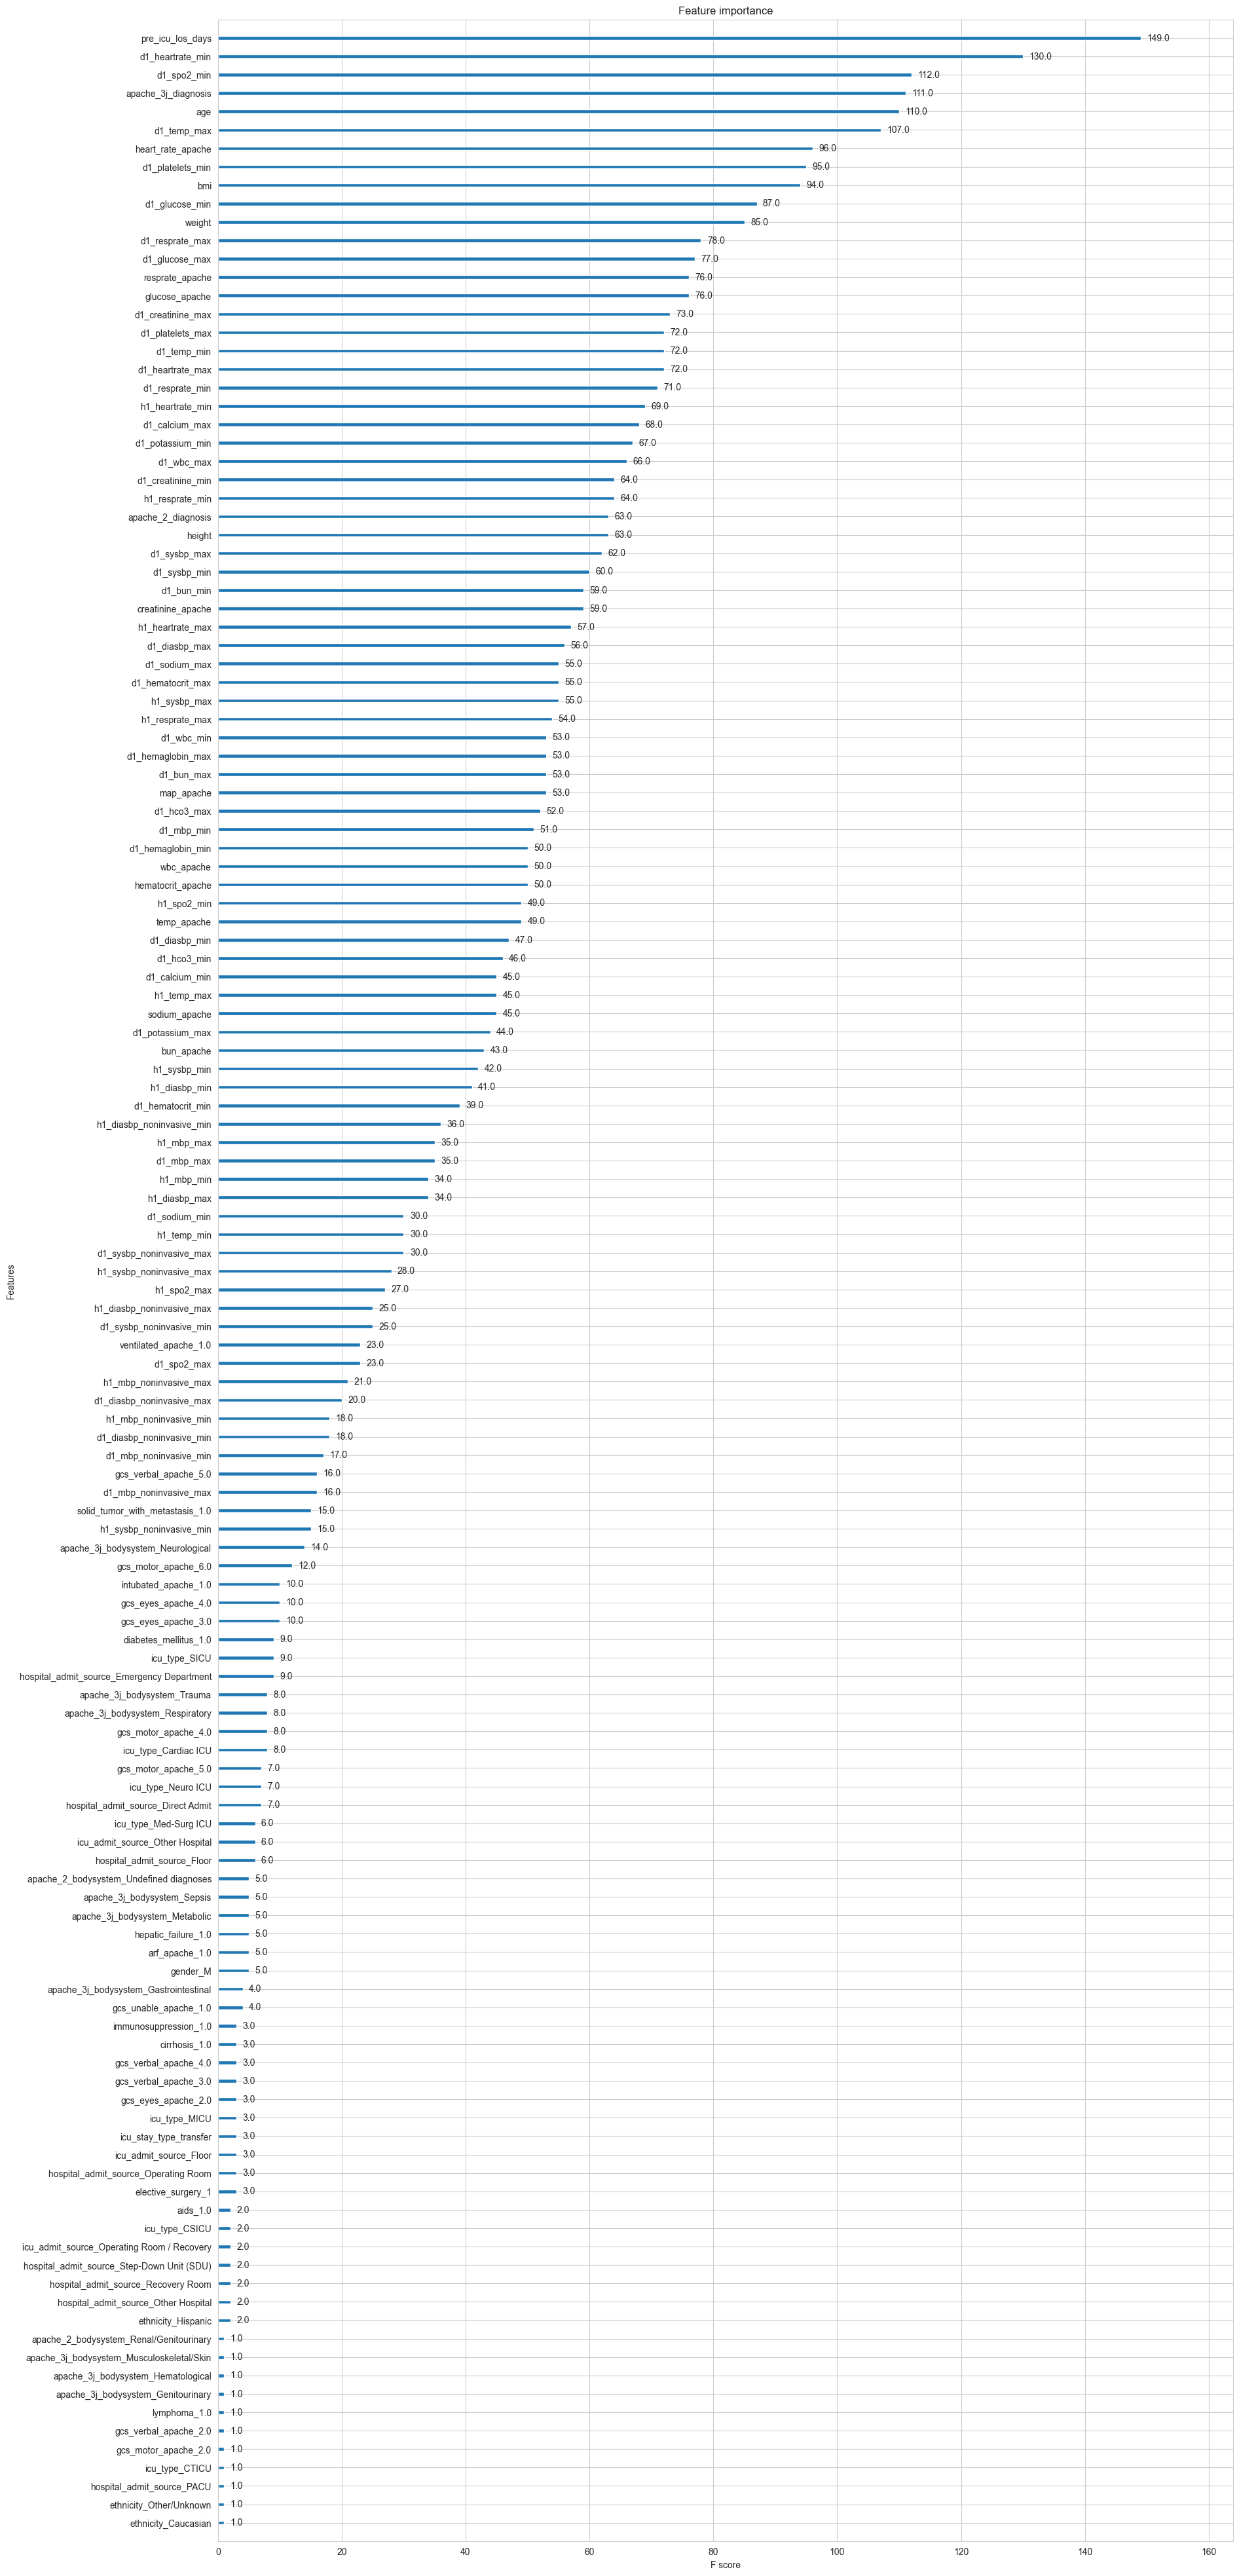

In [29]:
from xgboost import plot_importance

fig, ax = plt.subplots(1,1,figsize=(20,50))
plot_importance(xgb, ax=ax)

In [30]:
wids.iloc[10:20]
wids.loc[16, 'Description']

'The length of stay of the patient between hospital admission and unit admission'

<AxesSubplot: >

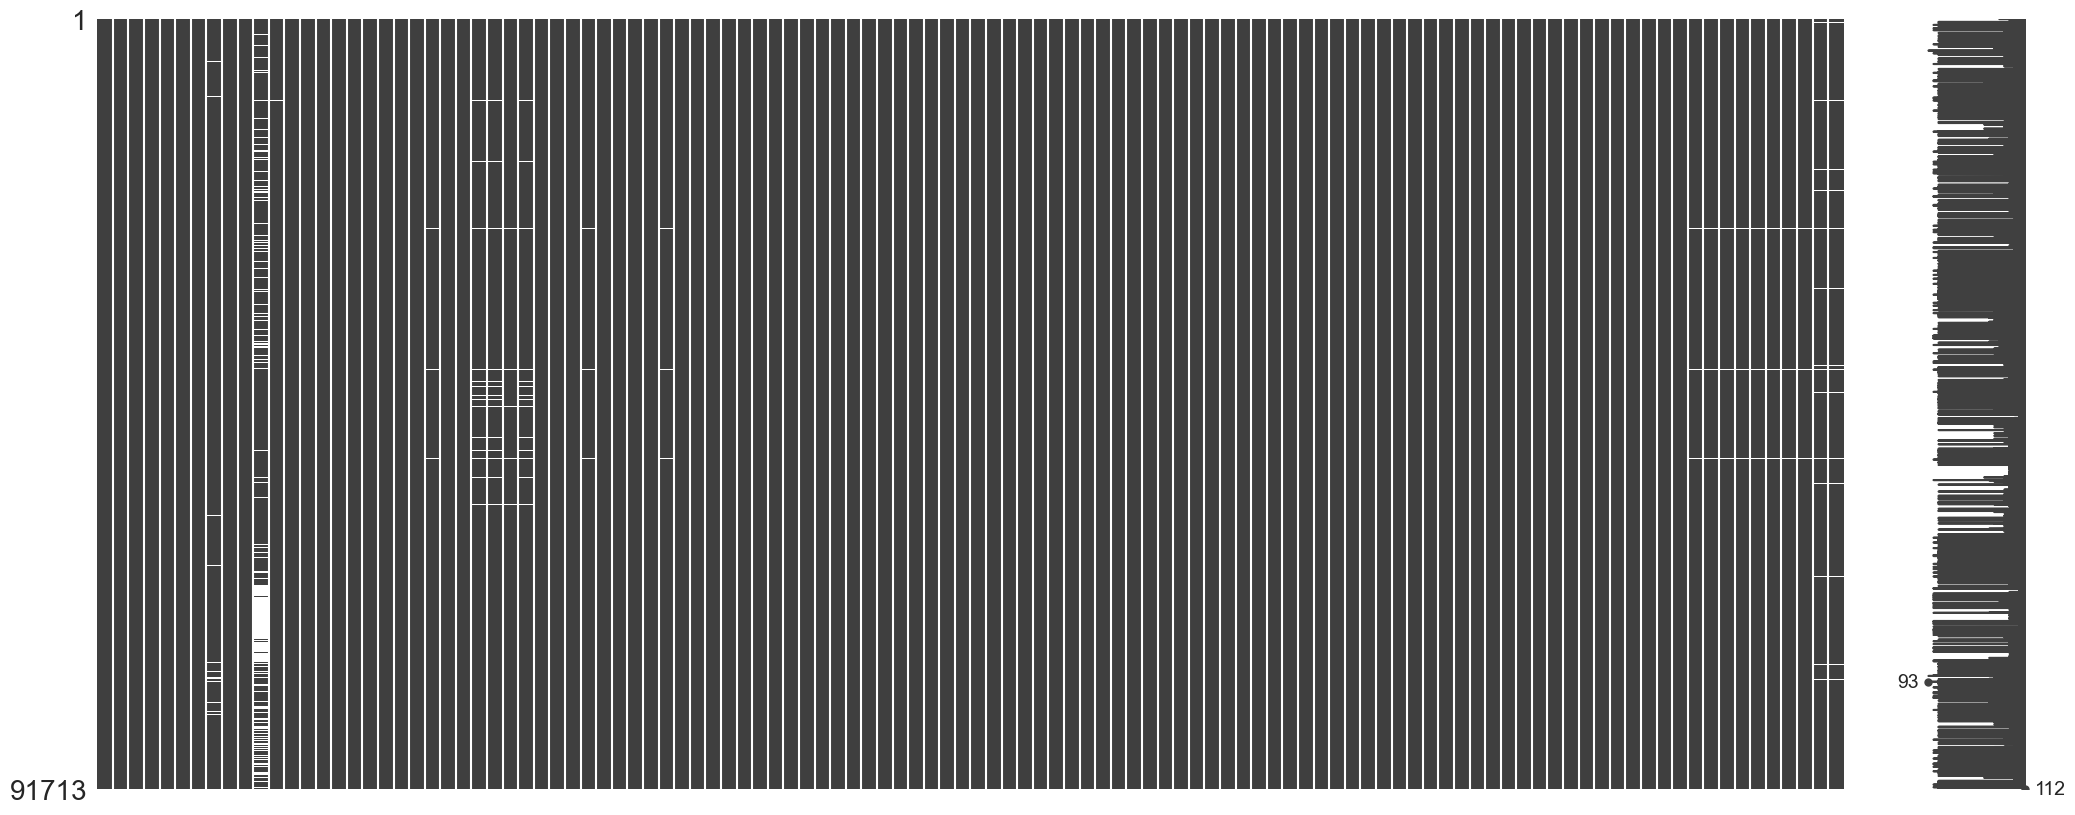

In [31]:
# This part is to check the randomness of the data
import missingno as msno
msno.matrix(df_training)